###Install Required Libraries
###Installs all external libraries needed for data loading, model training, evaluation, and visualisation.Ensures the runtime environment has the correct dependencies.

In [ ]:
# STEP 1: Install required libraries (runs once per runtime)
!pip -q install datasets transformers scikit-learn matplotlib


###Import Libraries and Set Reproducibility
###Imports required Python, ML, and DL libraries and fixes random seeds for reproducibility. Automatically selects GPU if available to speed up BERT fine-tuning.

In [ ]:
# STEP 2: Imports + reproducibility + device selection

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def set_seed(seed: int = 40) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(40)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
print("Using device:", device)


CUDA available: True
GPU name: Tesla T4
Using device: cuda


###Load IMDb Dataset
###Loads the IMDb movie review dataset using Hugging Face Datasets. Provides standard train and test splits for sentiment classification.

In [ ]:
# : Load IMDb dataset
dataset = load_dataset("imdb")
print(dataset)
print("Train size:", len(dataset["train"]))
print("Test size :", len(dataset["test"]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train size: 25000
Test size : 25000


##### Dataset and Task Explanation

This project addresses a binary sentiment classification task, where the objective is to predict whether a movie review expresses a positive or negative sentiment. The IMDb movie review dataset is used, which consists of 50,000 labelled reviews evenly split into training and test sets. Each review is labelled as either positive (1) or negative (0), making it suitable for supervised text classification.

The dataset is accessed via the Hugging Face Datasets library, which ensures reproducibility and consistency with prior research. This dataset is widely used in natural language processing literature, allowing results to be interpreted in the context of existing work.


###Validation Split (for learning curve + overfitting check)
###Splits the training data into training and validation sets. Allows monitoring of learning behaviour and detection of overfitting.

In [ ]:
# STEP 4: Create validation split from training data (avoid using TEST during training)
SEED = 40
split = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = dataset["test"]

print("Train size:", len(train_ds))
print("Val size  :", len(val_ds))
print("Test size :", len(test_ds))


Train size: 22500
Val size  : 2500
Test size : 25000


###Exploratory Data Analysis (EDA)
###Examines label distribution and sample reviews from the dataset. Helps understand data balance and text characteristics.

In [ ]:
# STEP 5: EDA
train_df = pd.DataFrame(train_ds)
val_df   = pd.DataFrame(val_ds)
test_df  = pd.DataFrame(test_ds)

print("Train label distribution (0=neg, 1=pos):")
print(train_df["label"].value_counts())

print("\nVal label distribution (0=neg, 1=pos):")
print(val_df["label"].value_counts())

print("\nTest label distribution (0=neg, 1=pos):")
print(test_df["label"].value_counts())

for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print("Label:", train_df.loc[i, "label"])
    print("Text snippet:", train_df.loc[i, "text"][:300], "...")


Train label distribution (0=neg, 1=pos):
label
1    11260
0    11240
Name: count, dtype: int64

Val label distribution (0=neg, 1=pos):
label
0    1260
1    1240
Name: count, dtype: int64

Test label distribution (0=neg, 1=pos):
label
0    12500
1    12500
Name: count, dtype: int64

--- Example 1 ---
Label: 0
Text snippet: Okay, so the introduction, with its hokey offer of a free coffin to anyone who dies of fright during the film, is so lame it's funny. And so the first "skull scene" is so drawn out and un-suspenseful it's funny. The actual plot of the movie is somewhat decent, there's at least a little bit of genuin ...

--- Example 2 ---
Label: 1
Text snippet: In War, Inc we find the logical extension of the current outsourcing of all war-related activities we are currently doing in Afghanistan and Iraq. If you are familiar with the antics of Halliburton, Kellogg, Brown & Root and Blackwater overseas you are already halfway home to fully appreciating the  ...

--- Example 3 ---
Label

###Baseline Model – TF-IDF + Logistic Regression
###Trains a traditional machine-learning baseline using TF-IDF features. Provides a strong non-LLM reference for comparison with BERT.

In [ ]:
# STEP 6: Baseline model (train on train, evaluate on test)

X_train = train_df["text"].tolist()
y_train = train_df["label"].to_numpy()

X_test = test_df["text"].tolist()
y_test = test_df["label"].to_numpy()

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=50000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train_tfidf, y_train)

baseline_preds = baseline_model.predict(X_test_tfidf)

baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_prec, baseline_rec, baseline_f1, _ = precision_recall_fscore_support(
    y_test, baseline_preds, average="binary", zero_division=0
)

print("Baseline (TF-IDF + Logistic Regression) Results")
print(f"Accuracy : {baseline_acc:.5f}")
print(f"Precision: {baseline_prec:.5f}")
print(f"Recall   : {baseline_rec:.5f}")
print(f"F1-score : {baseline_f1:.5f}")


Baseline (TF-IDF + Logistic Regression) Results
Accuracy : 0.88144
Precision: 0.88010
Recall   : 0.88320
F1-score : 0.88165


###Evaluate Baseline Model with Confusion Matrix
###Visualises classification errors made by the baseline model.Helps analyse false positives and false negatives.

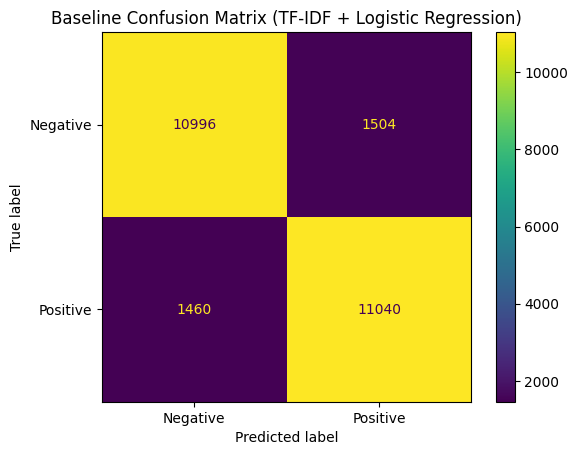

In [ ]:
# STEP 7: Baseline confusion matrix
cm_base = confusion_matrix(y_test, baseline_preds)
disp = ConfusionMatrixDisplay(cm_base, display_labels=["Negative", "Positive"])
disp.plot()
plt.title("Baseline Confusion Matrix (TF-IDF + Logistic Regression)")
plt.show()



##### Baseline Model Justification

A TF-IDF representation combined with Logistic Regression is used as a baseline model. TF-IDF captures the importance of words and phrases based on their frequency within and across documents, while Logistic Regression is a well-established linear classifier for text classification tasks.

Unigrams and bigrams are included to allow the model to capture short sentiment-bearing phrases such as negations and adjective–noun combinations. This baseline is known to perform strongly on the IMDb dataset, providing a meaningful reference point against which the performance of the fine-tuned BERT model can be evaluated.


###Initialize BERT Tokenizer and Hyperparameters
###Initialises the BERT tokenizer and defines training hyperparameters.Uses commonly recommended settings for BERT fine-tuning.

In [ ]:
# STEP 8: Setup tokenizer + hyperparameters for BERT fine-tuning

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 2
LR = 2e-5


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

###Tokenize Dataset Using Hugging Face Map
###Converts raw text into token IDs required by BERT.Applies padding and truncation for uniform input length.

In [ ]:
# STEP 9: Tokenize train/val/test (pre-tokenize for speed)
# Why: On-the-fly tokenization inside __getitem__ can be slow; pre-tokenization improves training speed.

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val   = val_ds.map(tokenize_function, batched=True)
tokenized_test  = test_ds.map(tokenize_function, batched=True)

tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print("Tokenization complete.")
print(tokenized_train[0])



Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenization complete.
{'label': tensor(0), 'input_ids': tensor([  101,  3100,  1010,  2061,  1996,  4955,  1010,  2007,  2049,  7570,
        14839,  3749,  1997,  1037,  2489, 13123,  2000,  3087,  2040,  8289,
         1997, 25966,  2076,  1996,  2143,  1010,  2003,  2061, 20342,  2009,
         1005,  1055,  6057,  1012,  1998,  2061,  1996,  2034,  1000,  7412,
         3496,  1000,  2003,  2061,  4567,  2041,  1998,  4895,  1011, 23873,
         3993,  2009,  1005,  1055,  6057,  1012,  1996,  5025,  5436,  1997,
         1996,  3185,  2003,  5399, 11519,  1010,  2045,  1005,  1055,  2012,
         2560,  1037,  2210,  2978,  1997, 10218,  2833,  2005,  2245,  1999,
         1996,  5248,  1997,  1996,  3494,  1010,  1998,  1996,  5436,  9792,
         2003, 11519,  2004,  5469, 17312,  2015,  2175,  1012,  1996,  3772,
         2003,  2779,  1010,  2025,  5621,  2919,  1012,  1026,  7987,  1013,
         1028,  1026,  7987,  1013,  1028, 10462,  1010,  2023,  3185,  2987,
       

##### BERT Architecture and Hyperparameter Justification

The BERT-base-uncased model is selected due to its strong performance on sentence-level classification tasks. BERT uses a multi-layer bidirectional transformer architecture, enabling it to capture contextual relationships between words based on their surrounding text.

For fine-tuning, a maximum sequence length of 128 tokens is used to balance contextual coverage and computational efficiency. A learning rate of 2e-5 and 2 training epochs are chosen, following common best practices for BERT fine-tuning to avoid overfitting while allowing effective adaptation to the sentiment classification task.


###Create DataLoaders for Training and Testing
###Creates DataLoader objects for efficient mini-batch processing.Enables fast and structured training, validation, and testing.

In [ ]:
# STEP 10: Create DataLoaders
train_loader = DataLoader(tokenized_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(tokenized_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(tokenized_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))


Train batches: 1407
Val batches  : 157
Test batches : 1563


###Define Training and Evaluation Functions
###Defines reusable functions for training and evaluation. Improves code clarity and avoids repetition.

In [ ]:
# STEP 11: Functions for clean, reusable code

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return acc, prec, rec, f1

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)

        preds.extend(pred.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    metrics = compute_metrics(labels_all, preds)
    return metrics, np.array(labels_all), np.array(preds)

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0.0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)


###Fine-Tune BERT Model and Load Pretrained BERT Model
###Fine-tunes the pre-trained BERT model on the training data. Evaluates performance on the validation set after each epoch.

In [ ]:
### Fine-Tune BERT Model (with Learning Curves)

# STEP 12: Train BERT and evaluate on VALIDATION each epoch (no test leakage)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

history = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(bert_model, train_loader, optimizer, scheduler)

    (val_acc, val_prec, val_rec, val_f1), _, _ = evaluate(bert_model, val_loader)

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1": val_f1
    })

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")
    print(f"Val Prec  : {val_prec:.4f}")
    print(f"Val Recall: {val_rec:.4f}")
    print(f"Val F1    : {val_f1:.4f}")

history_df = pd.DataFrame(history)
history_df


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2
Train Loss: 0.3648
Val Acc   : 0.8848
Val Prec  : 0.8845
Val Recall: 0.8831
Val F1    : 0.8838

Epoch 2/2
Train Loss: 0.1964
Val Acc   : 0.8908
Val Prec  : 0.8871
Val Recall: 0.8935
Val F1    : 0.8903


,epoch,train_loss,val_accuracy,val_precision,val_recall,val_f1
0,1,0.364841,0.8848,0.884491,0.883065,0.883777
1,2,0.196424,0.8908,0.887110,0.893548,0.890317


### Learning Curves (Overfitting Check)
###Plots training loss and validation F1-score across epochs. Used to assess training stability and overfitting.


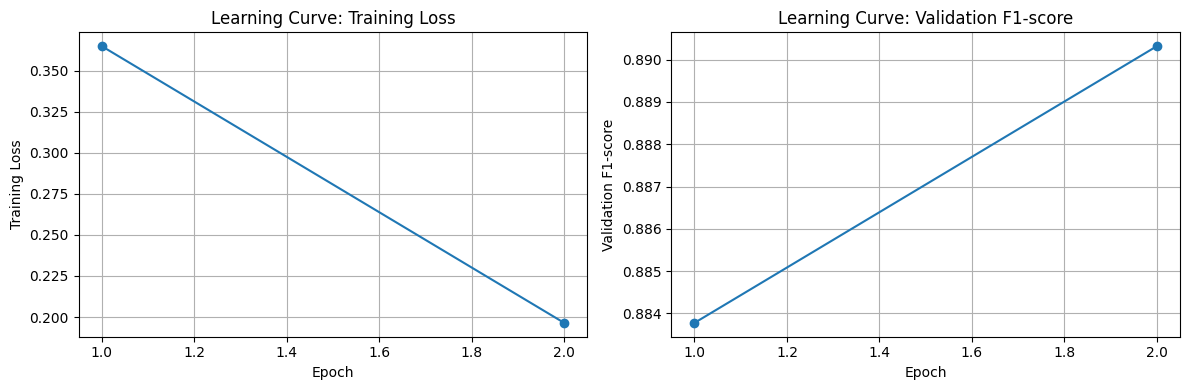

In [ ]:
# learning curves: Training Loss and Validation F1-score

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# LEFT: Training Loss
plt.subplot(1, 2, 1)
plt.plot(history_df["epoch"], history_df["train_loss"], marker="o")
plt.title("Learning Curve: Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid()

# RIGHT: Validation F1-score
plt.subplot(1, 2, 2)
plt.plot(history_df["epoch"], history_df["val_f1"], marker="o")
plt.title("Learning Curve: Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("Validation F1-score")
plt.grid()

plt.tight_layout()
plt.show()


###Evaluation on TEST Set (after training)
###Plots training loss and validation F1-score across epochs.Used to assess training stability and overfitting.

In [ ]:
# STEP 14: Evaluate once on TEST after training

(test_acc, test_prec, test_rec, test_f1), y_true, y_pred = evaluate(bert_model, test_loader)

print("Fine-Tuned BERT Results (TEST set)")
print(f"Accuracy : {test_acc:.5f}")
print(f"Precision: {test_prec:.5f}")
print(f"Recall   : {test_rec:.5f}")
print(f"F1-score : {test_f1:.5f}")


Fine-Tuned BERT Results (TEST set)
Accuracy : 0.89120
Precision: 0.88043
Recall   : 0.90536
F1-score : 0.89272


###Evaluate BERT Model with Confusion Matrix
###Displays the confusion matrix for the fine-tuned BERT model. Allows direct error comparison with the baseline model.

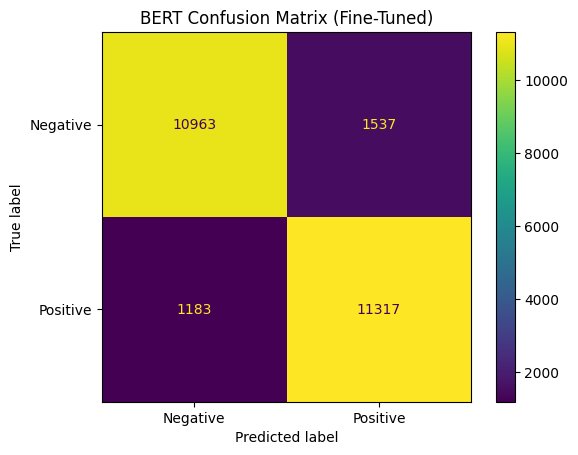

In [ ]:
# STEP 15: Confusion matrix for BERT

cm_bert = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm_bert, display_labels=["Negative", "Positive"])
disp.plot()
plt.title("BERT Confusion Matrix (Fine-Tuned)")
plt.show()


###Compare Baseline and BERT Performance
###Summarises baseline and BERT performance in a single table. Facilitates clear metric comparison.

In [ ]:
# STEP 16: Comparison table

results = pd.DataFrame([
    {"Model": "TF-IDF + Logistic Regression",
     "Accuracy": baseline_acc, "Precision": baseline_prec, "Recall": baseline_rec, "F1": baseline_f1},
    {"Model": "Fine-Tuned BERT (bert-base-uncased)",
     "Accuracy": test_acc, "Precision": test_prec, "Recall": test_rec, "F1": test_f1}
])

results


,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + Logistic Regression,0.88144,0.880102,0.88320,0.881648
1,Fine-Tuned BERT (bert-base-uncased),0.89120,0.880426,0.90536,0.892719


###Visual Comparison of Model Performance
###Visualises metric differences between baseline and BERT models. Highlights consistent performance improvements.

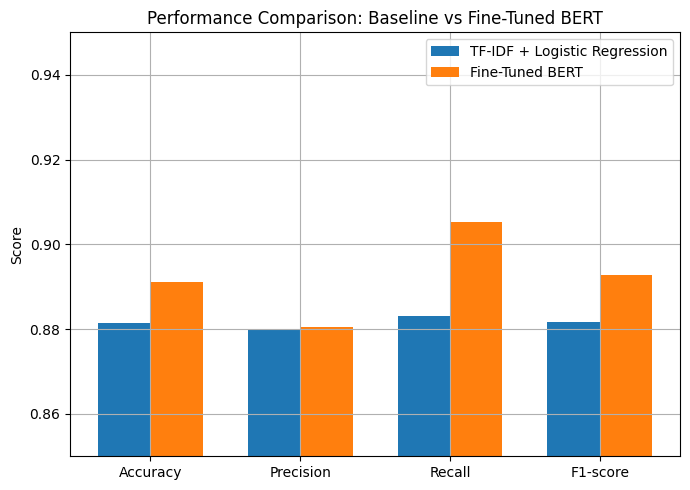

In [ ]:
# STEP 17: Multi-metric comparison plot

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

baseline_scores = [baseline_acc, baseline_prec, baseline_rec, baseline_f1]
bert_scores     = [test_acc, test_prec, test_rec, test_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, baseline_scores, width, label="TF-IDF + Logistic Regression")
plt.bar(x + width/2, bert_scores, width, label="Fine-Tuned BERT")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Fine-Tuned BERT")
plt.ylim(0.85, 0.95)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


##### Results Interpretation and Discussion

The fine-tuned BERT model achieves higher accuracy, precision, recall, and F1-score compared to the TF-IDF + Logistic Regression baseline. Although the absolute improvement is modest, it is consistent across all evaluation metrics.

This limited performance gap is expected, as the IMDb dataset contains long reviews with explicit sentiment expressions, allowing classical bag-of-words models to perform strongly. The confusion matrices indicate that BERT reduces both false positives and false negatives slightly, suggesting improved handling of contextual sentiment and negation compared to the baseline model.
